In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os

In [2]:

# Hyperparameters
lookback_window = 10  
input_size = 6
#TODO cut the days between        
output_size = 1     

num_layers = 1        

embed_dim = 64
hidden_size = 128  


alpha=1 #weight of directional loss
learning_rate = 0.0001
epochs = 40
batch_size = 32

#TODO: USD/TRY exchange rate input
#TODO: Faiz Enflasyon ve Piyasa Katılımcıları Anketi input

#TODO: Takas Verisi (model iyi sonuçlar vermezse son çare olarak kullanılabilir)

#TODO: Vadeli İşlem ve Opsiyon Borsası (VIOP) input (Çok karmaşıklaştırıyor gelecekte belki)
#TODO: Anlık Aracı Kurum Dağılımı  (çok karıştırabilir)



In [3]:
dataLocation="../Data/StandardizedData"
allcsvs=os.listdir(dataLocation)
# turn float64 to float 32

In [4]:
unnecessaryColumns=["Date","Pct_Change"]

from Scaler import Scaler
from sklearn.preprocessing import StandardScaler


# Can't do with minMax scaler we need Z scaler
#Rewrite Time
scaler = Scaler(0,50)
zScalerDic={}


def df_to_X_y(df,zScaler,window_size=5):
  lightWeightDf=df.drop(columns=unnecessaryColumns)
  df_as_np = zScaler.fit_transform(lightWeightDf.to_numpy())
  # df_as_np = lightWeightDf.to_numpy()

  X = []
  y = []
  open=[]
  for i in range(len(df_as_np)-window_size):
    row = [a for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size,3]
    y.append(label)
    open.append(df_as_np[i+window_size,0])
  return np.array(X), np.array(y),np.array(open)

In [5]:
XAll = np.zeros(1, dtype=np.int32)
yAll = np.zeros(1, dtype=np.int32)

for i in range(len(allcsvs)):
    rawData=pd.read_csv(os.path.join(dataLocation,allcsvs[i]))
    currentScaler=StandardScaler()
    zScalerDic[allcsvs[i]]=currentScaler
    Xtemp, yTemp, openTemp=df_to_X_y(rawData, currentScaler, lookback_window)
    nameTemp=np.array([allcsvs[i]]*yTemp.shape[0])

    if(XAll.shape[0] == 1 and yAll.shape[0] == 1):
        XAll=Xtemp
        yAll=yTemp
        nameAll=nameTemp
        openAll=openTemp
    else:
        XAll=np.concatenate((XAll,Xtemp),axis=0)
        yAll=np.concatenate((yAll,yTemp),axis=0)
        nameAll=np.concatenate((nameAll,nameTemp),axis=0)
        openAll=np.concatenate((openAll,openTemp),axis=0)
        
XAll=scaler.fit_transform(XAll)
yAll=scaler.fit_transform(yAll)
openAll=scaler.fit_transform(openAll)

Xtemp=None
yTemp=None
nameTemp=None
openTemp=None
rawData

,Date,Open,High,Low,Close,Volume,Days_Between,Pct_Change
0,2019-10-22 00:00:00+03:00,0.646781,0.652309,0.641253,0.652309,2.818350e+07,1.0,0.000000
1,2019-10-23 00:00:00+03:00,0.657837,0.663365,0.646781,0.663365,2.861088e+07,1.0,0.016949
2,2019-10-24 00:00:00+03:00,0.663365,0.679949,0.652309,0.663365,2.499212e+07,1.0,0.000000
3,2019-10-25 00:00:00+03:00,0.663365,0.663365,0.646781,0.663365,2.711898e+07,1.0,0.000000
4,2019-10-28 00:00:00+03:00,0.668893,0.668893,0.663365,0.663365,2.624481e+07,3.0,0.000000
...,...,...,...,...,...,...,...,...
1247,2024-10-16 00:00:00+03:00,4.050000,4.190000,3.990000,4.070000,7.700599e+07,1.0,0.004938
1248,2024-10-17 00:00:00+03:00,4.060000,4.160000,4.060000,4.160000,7.597829e+07,1.0,0.022113
1249,2024-10-18 00:00:00+03:00,4.170000,4.190000,4.050000,4.190000,7.844818e+07,1.0,0.007212
1250,2024-10-21 00:00:00+03:00,4.150000,4.230000,4.140000,4.150000,7.101958e+07,3.0,-0.009547


In [6]:
XAll.shape, yAll.shape, nameAll.shape, openAll.shape

((52345, 10, 6), (52345,), (52345,), (52345,))

In [7]:
def shuffle_data(X, y, names, open):
    """
    Shuffle the data while maintaining the correspondence between X and y.

    Parameters:
    X (numpy.ndarray): The input features tensor.
    y (numpy.ndarray): The target array.

    Returns:
    tuple: Shuffled X and y tensors.
    """
    assert len(X) == len(y), "X and y must have the same length."
    assert len(y) == len(names), "y and names must have the same length."

    # Generate a random permutation of indices
    #TODO add a seed for reproducibility
    #add seed to the code below
    np.random.seed(42)
    indices = np.random.permutation(len(X))
    # print(indices[:5])
    # Shuffle X and y
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    name_shuffled = names[indices]
    open_shuffled = open[indices]
    
    return X_shuffled, y_shuffled, name_shuffled, open_shuffled

In [8]:
X_shuffled, y_shuffled, name_shuffled, open_shuffled = shuffle_data(XAll, yAll, nameAll, openAll)

In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X_shuffled, y_shuffled, name_shuffled, open_shuffled):
        self.dataX = torch.tensor(X_shuffled, dtype=torch.float32)
        self.dataY = torch.tensor(y_shuffled, dtype=torch.float32)
        self.names = name_shuffled
        self.open = torch.tensor(open_shuffled, dtype=torch.float32)
        
    def __len__(self):
        return self.dataX.size(0)

    def __getitem__(self, idx):
        sequence = self.dataX[idx, :]
        target = self.dataY[idx]
        name = self.names[idx]
        open = self.open[idx]
        return sequence, target, name, open


#TODO  dropout or batch normalization
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        output, _ = self.lstm(x)
        last_output = output[:, -1, :]  # Take the output at the last time step
        return self.fc(last_output)


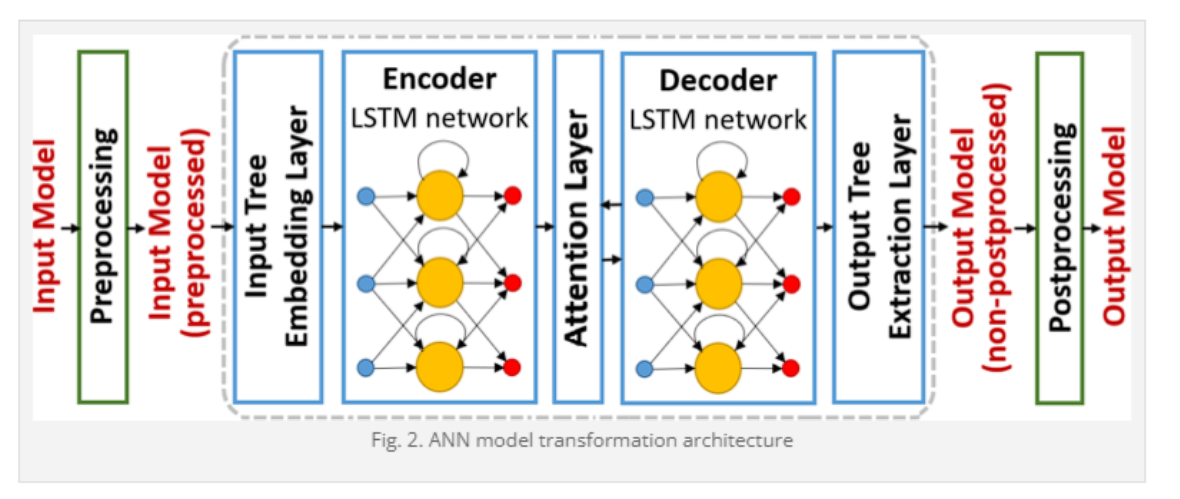

## Try this architecture

In [10]:
import torch.nn.functional as F


#TODO test and utilize
class AttentionMechanism(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionMechanism, self).__init__()
        self.attention_weights = nn.Linear(hidden_dim, 1, bias=False)
    
    def forward(self, lstm_outputs):
        # lstm_outputs: [batch_size, seq_len, hidden_dim]
        attention_scores = self.attention_weights(lstm_outputs).squeeze(-1)  # [batch_size, seq_len]
        attention_weights = F.softmax(attention_scores, dim=1)  # [batch_size, seq_len]
        weighted_output = torch.sum(lstm_outputs * attention_weights.unsqueeze(-1), dim=1)  # [batch_size, hidden_dim]
        return weighted_output, attention_weights

In [11]:
class LSTMDoubleAttentionModel(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, output_dim, num_layers=1, bidirectional=False):
        super(LSTMDoubleAttentionModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.directions = 2 if bidirectional else 1

        # Embedding layer (optional: use if input is categorical or needs projection)
        self.embedding = nn.Linear(input_dim, embed_dim)  # Replace with nn.Embedding if needed
        
        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, 
                                    batch_first=True, bidirectional=bidirectional)
        
        # Attention
        self.attention = AttentionMechanism(hidden_dim * self.directions)
        
        # Decoder LSTM
        self.decoder_lstm = nn.LSTM(hidden_dim * self.directions, hidden_dim, num_layers,
                                    batch_first=True, bidirectional=bidirectional)
        
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim * self.directions, output_dim)
    
    def forward(self, x):
        # x shape: [batch_size, seq_len, input_dim]
        
        # Embedding
        embedded = self.embedding(x)  # [batch_size, seq_len, embed_dim]
        
        # Encoder LSTM
        encoder_out, _ = self.encoder_lstm(embedded)  # [batch_size, seq_len, hidden_dim * directions]
        
        # Attention
        attention_out, attention_weights = self.attention(encoder_out)  # [batch_size, hidden_dim * directions]
        
        # Prepare Decoder Input (sequence length 1)
        decoder_input = attention_out.unsqueeze(1)  # [batch_size, 1, hidden_dim * directions]
        
        # Decoder LSTM
        decoder_out, _ = self.decoder_lstm(decoder_input)  # [batch_size, 1, hidden_dim * directions]
        
        # Final Prediction
        output = self.fc(decoder_out.squeeze(1))  # [batch_size, output_dim]
        
        return output, attention_weights

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device}")

Using cuda


In [13]:
X_train = X_shuffled[:int(0.8*len(X_shuffled))]
y_train = y_shuffled[:int(0.8*len(y_shuffled))]
name_train = name_shuffled[:int(0.8*len(name_shuffled))]
open_train = open_shuffled[:int(0.8*len(open_shuffled))]

X_val = X_shuffled[int(0.8*len(X_shuffled)):]
y_val = y_shuffled[int(0.8*len(y_shuffled)):]
name_val = name_shuffled[int(0.8*len(name_shuffled)):]
open_val = open_shuffled[int(0.8*len(open_shuffled)):]
# I don't need open in the train set but it exists just because consistency

len(X_train), len(X_val)

(41876, 10469)

In [14]:
trainDataset = TimeSeriesDataset(X_train, y_train,name_train, open_train)
train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=False)

#Dataset for validation
valDataset = TimeSeriesDataset(X_val, y_val,name_val ,open_val)
val_loader = DataLoader(valDataset, batch_size=batch_size, shuffle=False)

# Cross-validation: On non-overlapping sequential splits for evaluation.

In [15]:
def directional_loss(outputs, targets, sequences):
    # Calculate the direction of predictions and actual values
    pred_dir = (outputs.squeeze() - sequences[:, -1, 3]) >= 0
    true_dir = (targets - sequences[:, -1, 3]) >= 0
    # Penalize mismatched directions
    mismatches = (pred_dir != true_dir).float()
    return mismatches.mean()

def inverseScale(sequence, scaler, name, predIndex, dataIndex):
    placeHolder=np.zeros((batch_size,lookback_window,input_size))
    placeHolder[:,-1,dataIndex]=sequence.cpu().numpy()
    reverseScaled=scaler.inverse_transform(placeHolder[predIndex,:,:])
    return zScalerDic[name].inverse_transform(reverseScaled)

In [16]:
dirLossBool=False

def train_one_epoch(model,optimizer,criterion,train_loader, scheduler):
    model.train()
    model.to(device)
    epoch_loss = 0

    for sequences, targets, name, open in train_loader:
        sequences, targets = sequences.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs, att = model(sequences)
        mse=criterion(outputs.squeeze(), targets)
        dir_loss = directional_loss(outputs, targets, sequences)

        loss = mse + alpha * dir_loss * dirLossBool
        # loss = mse

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()


    scheduler.step()
    return epoch_loss    

calculateProfit=True
def validate(model,criterion,val_loader):
    model.eval()
    model.to(device)
    val_loss = 0
    DA=0
    capital = 0
    with torch.no_grad():
        for sequences, targets, name, open in val_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            outputs, att = model(sequences)

            #Start of the DA code
            dirMatrix=(outputs.squeeze() - sequences[:,-1,3])>=0
            truthDirMatrix=(targets - sequences[:,-1,3])>=0
            DA+=(dirMatrix==truthDirMatrix).sum().item()
            #end

            mse=criterion(outputs.squeeze(), targets)
            dir_loss = directional_loss(outputs, targets, sequences)

            loss = mse + alpha * dir_loss*dirLossBool


            val_loss += loss.item()
            if(not calculateProfit):
                continue
            outputs=outputs.squeeze()
            for index in range(0, targets.shape[0]):

                realVal=inverseScale(targets[index],scaler,name[index],index, 3)[-1,3]
                predVal=inverseScale(outputs[index],scaler,name[index],index, 3)[-1,3]
                nextOpen=inverseScale(open[index],scaler,name[index],index, 0)[-1,0]

                #code for the previous value scaling
                # realPrevVal=zScalerDic[name[index]].inverse_transform(scaler.inverse_transform(sequences[index,-2:,:].cpu().numpy()))[-1,3]

                if predVal > nextOpen:  # Buy
                    profit = (realVal - nextOpen) 
                elif predVal < nextOpen:  # Short
                    profit = (nextOpen - realVal) 
                else:  # No trade
                    profit = 0

                capital += (profit)  # Update capital
    return val_loss, DA, capital
    # print(f"Validation Loss: {val_loss / len(val_loader):.4f}")

In [17]:
from torch.optim.lr_scheduler import StepLR

# Initialize model, loss function, and optimizer
model = LSTMDoubleAttentionModel(input_size, embed_dim, hidden_size, output_size, num_layers=num_layers, bidirectional=True)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [18]:
loaded=False
if(input("Do you want to load the previous model? (y/n)")=="y"):
    model.load_state_dict(torch.load("./Weights/model.pth", weights_only=True))
    model.eval()
    loaded=True

In [19]:
valLosses=[]
trainLosses=[]
DAvals=[]
earlyStopper=0
# Training loop
temp=epochs
if(loaded):
    epochs=0
for epoch in range(epochs):

    epoch_loss=train_one_epoch(model,optimizer,criterion,train_loader, scheduler)
    val_loss, direction, profit=validate(model,criterion,val_loader)

    val_loss=val_loss / len(val_loader)
    epoch_loss=epoch_loss / len(train_loader)
    direction=direction / len(nameAll)
    
    valLosses.append(val_loss)
    trainLosses.append(epoch_loss)
    DAvals.append(direction)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Directional Accuracy: {direction:.4f}, Profit: {profit:.4f}")
    if(val_loss<valLosses[-1]):
        earlyStopper+=1
        if(earlyStopper>5):
            print("Early Stopping")
            break
    else:
        earlyStopper=0



if(loaded):
    epochs=temp
    temp=None

Epoch 1/40, Loss: 86.9358, Validation Loss: 17.7716, Directional Accuracy: 0.0962, Profit: -2824.7405
Epoch 2/40, Loss: 7.6439, Validation Loss: 2.9742, Directional Accuracy: 0.1063, Profit: 4654.2734
Epoch 3/40, Loss: 1.6615, Validation Loss: 1.0328, Directional Accuracy: 0.0976, Profit: 311.7890
Epoch 4/40, Loss: 0.6412, Validation Loss: 0.6761, Directional Accuracy: 0.0942, Profit: -3975.8306
Epoch 5/40, Loss: 0.3726, Validation Loss: 0.3162, Directional Accuracy: 0.1033, Profit: 2301.9174
Epoch 6/40, Loss: 0.2872, Validation Loss: 0.2416, Directional Accuracy: 0.0987, Profit: 724.9645
Epoch 7/40, Loss: 0.2488, Validation Loss: 0.2046, Directional Accuracy: 0.1034, Profit: 3604.3436
Epoch 8/40, Loss: 0.2303, Validation Loss: 0.1887, Directional Accuracy: 0.1064, Profit: 4636.0946
Epoch 9/40, Loss: 0.2198, Validation Loss: 0.1820, Directional Accuracy: 0.1075, Profit: 4616.2985
Epoch 10/40, Loss: 0.2136, Validation Loss: 0.1772, Directional Accuracy: 0.1079, Profit: 4477.1720
Epoch 1

In [20]:
# import matplotlib.pyplot as plt
# import numpy as np
# startPoint=30
# # Example float array
# val_array = valLosses[startPoint:]
# train_array = trainLosses[startPoint:]

# # Create an x-axis for the data points
# x = np.arange(len(train_array))
# y = np.arange(len(val_array))

# # Plot the graph
# plt.plot(x, train_array, marker='o', linestyle='-', color='b', label='Train Loss')
# plt.plot(y, val_array, marker='o', linestyle='-', color='r', label='Val Loss')

# # Add labels and title
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.title('Float Array Plot')
# plt.legend()

# plt.grid(True)
# plt.show()

In [21]:
# startPoint=15
# da_array = DAvals[startPoint:]
# # Create an x-axis for the data points
# x = np.arange(len(da_array))

# # Plot the graph
# plt.plot(x, da_array, marker='o', linestyle='-', color='b', label='Directional success')
# # Add labels and title
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.title('Float Array Plot')
# plt.legend()

# plt.grid(True)
# plt.show()

In [22]:
if(not loaded and input("Do you want to save the model? (y/n)")=="y"):
    torch.save(model.state_dict(), "./Weights/lr_dec_BiDir6200.pth")

In [23]:
# Extract one batch of data for testing
model.to(device)
for sequences, targets, name, open in train_loader:
    testInput = sequences.to(device)  # Sequence data
    # testInput.to(device)
    print(f"Test Input Shape: {testInput.shape}")
    realOutput = targets   # Ground truth output
    break

# Ensure the model is in evaluation mode
model.eval()

# Predict using the model
with torch.no_grad():  # Disable gradient calculations for inference
    predicted, att = model(testInput) # Forward pass through the model
    predicted=predicted.squeeze()
# Check shapes and results
print(f"Predicted Output Shape: {predicted.shape}")

predicted
# testInput.shape

Test Input Shape: torch.Size([32, 10, 6])
Predicted Output Shape: torch.Size([32])


tensor([23.0708, 13.7689, 36.2973, 12.8128, 10.1537, 19.9538, 32.4030, 14.6738,
        25.3991, 14.0790, 28.9539, 25.9049, 11.5357, 15.0943, 11.8914, 11.0357,
        12.6061, 26.1578, 13.0953, 16.1365, 12.1550, 32.4615, 11.0882, 35.2191,
        29.0208, 28.3859, 27.3044, 35.7956, 12.8247, 17.4292, 18.8766, 14.1144],
       device='cuda:0')

In [24]:
realOutput

tensor([22.7607, 13.9064, 38.1664, 12.8154, 10.2141, 19.9622, 32.4496, 14.8337,
        24.8467, 14.1724, 28.9589, 26.8786, 11.5357, 15.0554, 11.9663, 11.0366,
        12.5290, 25.0590, 13.5174, 16.0576, 12.1851, 32.5694, 11.0653, 34.7276,
        28.5664, 28.3039, 27.4845, 33.7297, 12.8250, 17.6794, 18.8024, 14.0642])

In [25]:
sequences[1]

tensor([[1.5686e+01, 1.5906e+01, 1.5744e+01, 1.5900e+01, 7.8264e+00, 1.6592e+01],
        [1.5585e+01, 1.5755e+01, 1.5551e+01, 1.5610e+01, 8.8968e+00, 9.7202e-03],
        [1.5221e+01, 1.5369e+01, 1.5041e+01, 1.5131e+01, 8.6726e+00, 9.7202e-03],
        [1.4727e+01, 1.5043e+01, 1.4795e+01, 1.4991e+01, 8.6295e+00, 9.7202e-03],
        [1.4543e+01, 1.4752e+01, 1.4565e+01, 1.4717e+01, 8.6079e+00, 9.7202e-03],
        [1.4222e+01, 1.4444e+01, 1.4261e+01, 1.4364e+01, 8.6408e+00, 1.6592e+01],
        [1.3817e+01, 1.4120e+01, 1.3902e+01, 1.3957e+01, 8.6194e+00, 9.7202e-03],
        [1.3839e+01, 1.4047e+01, 1.3889e+01, 1.3758e+01, 8.6508e+00, 9.7202e-03],
        [1.3635e+01, 1.3812e+01, 1.3775e+01, 1.3690e+01, 9.3899e+00, 9.7202e-03],
        [1.3586e+01, 1.3848e+01, 1.3807e+01, 1.3758e+01, 9.4191e+00, 9.7202e-03]])

In [26]:
predIndex=1
prediction=np.zeros((32,lookback_window,6))
real=np.zeros((32,lookback_window,6))
openNext=np.zeros((32,lookback_window,6))
openNext[:,-1,0]=open.cpu().numpy()
real[:,-1,3]=realOutput.cpu().numpy()
prediction[:,-1,3]=predicted.cpu().numpy()

In [27]:
reverseScaled=scaler.inverse_transform(real[predIndex,:,:])
zScalerDic[name[predIndex]].inverse_transform(reverseScaled)[-1,3], "real val"

(25.543865485416806, 'real val')

In [28]:
reverseScaledP=scaler.inverse_transform(prediction[predIndex,:,:])
zScalerDic[name[predIndex]].inverse_transform(reverseScaledP)[-1,3], "prediction"

(25.166522884825817, 'prediction')

In [29]:
reverseScaledO=scaler.inverse_transform(openNext[predIndex,:,:])
zScalerDic[name[predIndex]].inverse_transform(reverseScaledO)[-1,0], "open"

(25.83440399788412, 'open')

In [30]:
def calculateProfit(model,val_loader):
    model.eval()
    model.to(device)
    profit=0
    capital=0
    with torch.no_grad():
        for sequences, targets, name, open in val_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            outputs, att = model(sequences)
            outputs=outputs.squeeze()

            for index in range(0, targets.shape[0]):

                realVal=inverseScale(targets[index],scaler,name[index],index, 3)[-1,3]
                predVal=inverseScale(outputs[index],scaler,name[index],index, 3)[-1,3]
                nextOpen=inverseScale(open[index],scaler,name[index],index, 0)[-1,0]

                #code for the previous value scaling
                # realPrevVal=zScalerDic[name[index]].inverse_transform(scaler.inverse_transform(sequences[index,-2:,:].cpu().numpy()))[-1,3]

                if predVal > nextOpen:  # Buy
                    profit = (realVal - nextOpen) 
                elif predVal < nextOpen:  # Short
                    profit = (nextOpen - realVal) 
                else:  # No trade
                    profit = 0

                capital += (profit)  # Update capital
                # print(f"Profit: {profit:.4f} Real Val: {realVal:.4f} Pred Val: {predVal:.4f} Next Open: {nextOpen:.4f}")
    return capital

In [31]:
calculateProfit(model,val_loader)

6201.201549075434